In [1]:
import os
import json

import numpy as np
import tensorflow as tf

from itertools import permutations

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

%matplotlib inline

In [42]:
# load the data

file_name = "polynome_ready_for_training.json"

with open(file_name, "r") as f:
    data = json.load(f)
    
print("keys: ", list(data.keys()))

keys:  ['states', 'actions', 'scores']


In [74]:
import gym
from gym import error, spaces, utils
from gym.utils import seeding

from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import numpy as np
import json



class MDPnas(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, data_path, reward_penalty=0.5, naction_ending=5):
        super(MDPnas, self).__init__()

        self.data_path = data_path
        self.X_train, self.y_train, self.X_test, self.y_test, self.r_train, self.r_test = self.load_data()
        self.current_fi = -1
        self.current_step = 0
        self.reward_penalty = reward_penalty
        self.naction_ending = naction_ending

        self.status = "train"
        self.history = []

        self.X_active = self.X_train if self.status == "train" else self.X_test
        self.r_active = self.r_train if self.status == "train" else self.r_test

    def load_data(self):
        with open(self.data_path, "r") as f:
            data = json.load(f)
        X, y, r = [], [], []
        n_networks = len(np.unique(data["actions"]))
        n_func = len(data["states"]) // n_networks

        for f_i in range(n_func):
            scores_i = []
            actions_i = []
            for n_i in range(n_networks):
                i = f_i * n_networks + n_i
                scores_i.append(data["scores"][i])
                actions_i.append(data["actions"][i])

            X.append(data["states"][i])
            y.append(actions_i)
            r.append(scores_i)

        X = np.array(X)
        y = np.array(y)
        r = np.array(r)

        # fix action ordering
        idx_order = np.argsort(y[0])
        y = y[:, idx_order]
        r = r[:, idx_order]

        idxs = np.arange(X.shape[0])
        test_split = 0.33 * len(idxs)

        np.random.shuffle(idxs)

        idxs_train = idxs[:test_split]
        idxs_test = idxs[test_split:]

        X_train = X[idxs_train]
        y_train = y[idxs_train]
        r_train = r[idxs_train]

        X_test = X[idxs_test]
        y_test = y[idxs_test]
        r_test = r[idxs_test]

        return sort_by_x(X_train), y_train, sort_by_x(X_test), y_test, r_train, r_test

    def compute_reward(self, action):

        full_reward = self.r_train[self.current_fi, action]
        discounted_reward = full_reward * \
            np.exp(-self.current_step*self.reward_penalty)

        return discounted_reward

    # obs, reward, done, info

    def step(self, action):

        # Stop condition: end of samples or self.naction_ending times same action
        done = (self.current_step >= self.naction_ending and len(np.unique(
            self.history[-self.naction_ending:])) == 1) or (self.current_step == self.X_active.shape[0]//2)

        # Mask
        step_mask = np.zeros(self.X_active.shape[0]//2)
        step_mask[:self.current_step] = 1.0

        new_obs = self.X_active[self.current_step].reshape(
            (2, self.X_active.shape[0]//2))
        new_obs[0, :] = new_obs[0, :] * step_mask
        new_obs[1, :] = new_obs[1, :] * step_mask

        return new_obs, self.compute_reward(action), done, ""

    def reset(self, idx=-1, status=""):

        if status in ["train", "test"]:
            self.status = status
        else:
            self.status = "train"

        self.X_active = self.X_train if self.status == "train" else self.X_test
        self.r_active = self.r_train if self.status == "train" else self.r_test

        if idx != -1:
            self.current_fi = idx
        else:
            self.current_fi = np.random.randint(self.X_active.shape[0])

        self.current_step = 0
        self.history = []

    def render(self, mode='human'):
        pass


In [69]:
X.shape

(900, 160)

In [70]:
r.shape

(900, 5)

In [71]:
y

array([[0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       ...,
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4]])

In [72]:
r

array([[ 0.8525183 ,  0.14622227,  0.66343661,  0.52448777,  0.39631483],
       [ 0.97352958,  0.99339766,  0.97545878,  0.        ,  0.76578867],
       [ 0.99836124,  0.99856726,  0.97227919, -1.        , -1.        ],
       ...,
       [ 0.96669012,  0.14067554,  0.94474214, -1.        , -1.        ],
       [ 0.66269388,  0.        ,  0.84153804, -1.        ,  0.3265097 ],
       [ 0.96441754,  0.99611789,  0.98948813,  0.52658342,  0.44948581]])

In [3]:
# keep only winning networks
X, y = [], []
n_networks = len(np.unique(data["actions"]))
n_func = len(data["states"]) // n_networks
# print(n_networks, n_func)
for f_i in range(n_func):
    best_network = None
    best_score = -2
    for n_i in range(n_networks):
        i = f_i * n_networks + n_i
        score = data["scores"][i]
        if score > best_score:
            best_score = score
            best_network = data["actions"][i]
    X.append(data["states"][i])
    y.append(best_network)

In [5]:
X = np.array(X)
y = np.array(y)

# X = np.array(data["states"])
y = tf.keras.utils.to_categorical(y, len(np.unique(y)))

print("X shape: ", X.shape)
print("y shape: ", y.shape)

X shape:  (900, 160)
y shape:  (900, 5)


In [6]:
def sort_by_x(X):
    for i,data in enumerate(X):
        middle_point = int(len(data)/2)
        x = data[:middle_point]
        y = data[middle_point:]
        sorted_xy = np.asarray([[a,x] for a,x in sorted(zip(data[:middle_point],data[middle_point:]))])
        new_data = np.concatenate((sorted_xy[:,0], sorted_xy[:,1]), axis=None)
        X[i] = new_data
    return X

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
    test_size=0.33, 
    random_state=42
)

In [8]:
Xt_sorted = sort_by_x(X_train)
Xtest_sorted = sort_by_x(X_test)

In [9]:
from scipy.spatial.distance import cdist

In [10]:
D = cdist(Xtest_sorted[:, 80:], Xt_sorted[:, 80:], metric="minkowski")

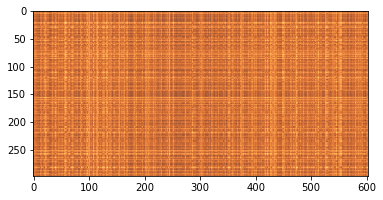

In [11]:
plt.imshow(D, alpha=0.8, cmap='YlOrBr_r')

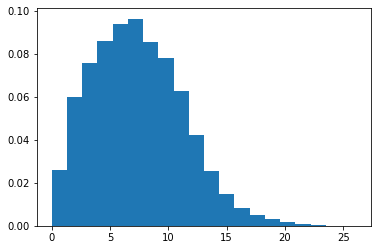

In [12]:
plt.hist(D.ravel(), bins=20, density=True)
plt.show()

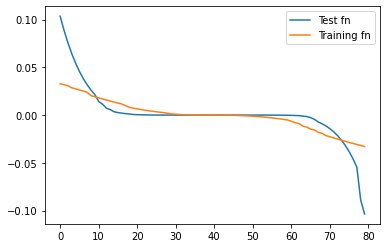

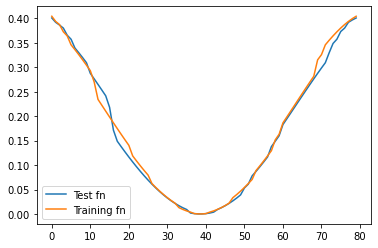

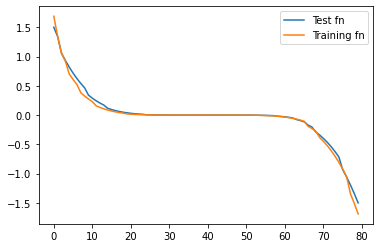

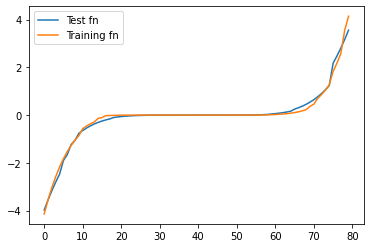

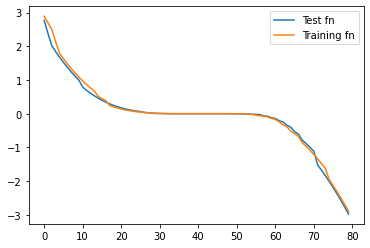

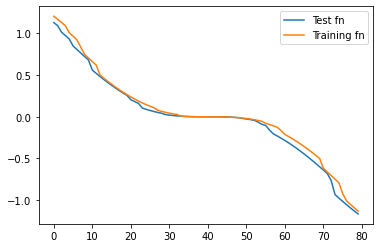

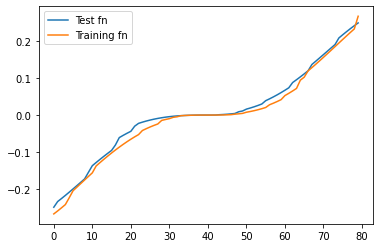

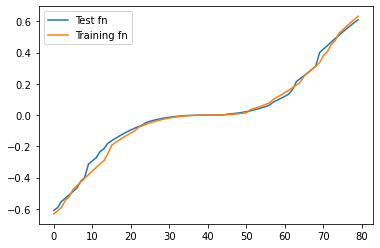

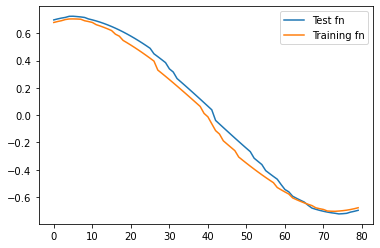

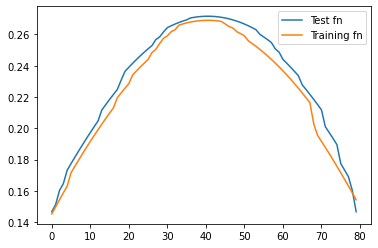

In [13]:
for i_test in range(Xtest_sorted.shape[0])[:10]:
    closest = np.argmin(D[i_test,:])
    plt.plot(Xtest_sorted[i_test, 80:], label="Test fn")
    plt.plot(Xt_sorted[closest, 80:], label="Training fn")
    plt.legend()
    plt.show()

In [38]:
np.argmax(y_test, axis=1).shape

(297,)

In [36]:
ypred = np.argmax(y_train[np.argmin(D, axis=1)], axis=1)

ypred.shape

(297,)

In [39]:
sum([1 for i in range(len(y_test)) if np.argmax(y_test, axis=1)[i] == ypred[i]])

98

In [24]:
np.argmax(y_test[np.argmin(D, axis=0)], axis=1)

array([[0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

# Bandits

In [ ]:
y_train[np.argmin(D, axis=1)]= 

# NN

In [ ]:
# Creation of the model

def generate_nn(input_shape, output_shape, nunits=[10, 10], activation=["relu", "relu"]):

    assert len(nunits) == len(activation)

    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=input_shape))

    for i, (nunits_, activation_) in enumerate(zip(nunits, activation)):
        model.add(
            tf.keras.layers.Dense(nunits_, activation=activation_, name=f"layer_{i+1}")
        )

    model.add(tf.keras.layers.Dense(output_shape, activation="softmax"))

    return model

nlayers = 3
config = dict(
    nunits=[100]*nlayers,
    activation=["relu"]*nlayers
)

model = generate_nn(X.shape[1:], y.shape[1], **config)

model.summary()

In [ ]:
model.compile(
    optimizer="sgd",
    loss="categorical_crossentropy",
    metrics=["acc"]
)

history = model.fit(X_train, y_train, 
    epochs=100, 
    batch_size=16, 
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[WandbCallback()]
).history

In [ ]:
plt.figure()
plt.plot(history["acc"], label="train")
plt.plot(history["val_acc"], label="test")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.legend()

plt.show()

In [ ]:
from sklearn import svm
from sklearn.metrics import accuracy_score

In [ ]:
clf = svm.SVC(kernel="poly", gamma='auto')
clf.fit(X_train, np.argmax(y_train, axis=1))

In [ ]:
y_train_pred = clf.predict(X_train)
acc_train = accuracy_score(np.argmax(y_train, axis=1), y_train_pred)

y_pred = clf.predict(X_test)
acc_val = accuracy_score(np.argmax(y_test, axis=1), y_pred)

In [ ]:
print(f'Train accuracy: {np.round(acc_train, 2)}\nTest accuracy: {np.round(acc_val, 2)}')

In [ ]:
from sklearn.linear_model import PassiveAggressiveClassifier

In [ ]:
clf = PassiveAggressiveClassifier(max_iter=1000, random_state=0, tol=1e-3)
clf.fit(X_train, np.argmax(y_train, axis=1))

In [ ]:
y_train_pred = clf.predict(X_train)
acc_train = accuracy_score(np.argmax(y_train, axis=1), y_train_pred)

y_pred = clf.predict(X_test)
acc_val = accuracy_score(np.argmax(y_test, axis=1), y_pred)

In [ ]:
print(f'Train accuracy: {np.round(acc_train, 2)}\nTest accuracy: {np.round(acc_val, 2)}')